<font size = "+3"><strong>Air Pollution in Beijing </strong></font>

<font size = "+1"><strong>Forecast pollution level of a city every 6 hours using ARIMA Model</strong></font>

# Prepare

## Import

**Task 1:** Import all necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

**Task 2:** Create a wrangle function to clean the dataset

In [14]:
# Create a wrangle function
def wrangle(filepath):
    df  = pd.read_csv(filepath)

    # Combine columns to create a timestamp
    df["timestamp"] = pd.to_datetime(df[["year","month","day","hour"]])
    df.index = df["timestamp"]


    # Mask to readings less than 500
    df = df[df["pm2.5"] <= 500]

    # Localize the timestamp
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Hong_Kong")

    # Resample by 6 hours
    y = df
    y = df["pm2.5"].resample("6H").mean().fillna(method = "ffill")

    return y

y = wrangle("PRSA_data_2010.1.1-2014.12.31.csv")

**Task 3:** Inspect dataframe

In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 08:00:00+08:00 to 2015-01-01 07:00:00+08:00
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   No         43824 non-null  int64         
 1   year       43824 non-null  int64         
 2   month      43824 non-null  int64         
 3   day        43824 non-null  int64         
 4   hour       43824 non-null  int64         
 5   pm2.5      41757 non-null  float64       
 6   DEWP       43824 non-null  int64         
 7   TEMP       43824 non-null  float64       
 8   PRES       43824 non-null  float64       
 9   cbwd       43824 non-null  object        
 10  Iws        43824 non-null  float64       
 11  Is         43824 non-null  int64         
 12  Ir         43824 non-null  int64         
 13  timestamp  43824 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(8), object(1)
memory usage: 5.0+ MB


In [10]:
y.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,timestamp
timestamp,,,,,,,,,,,,,,
2010-01-01 08:00:00+08:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
2010-01-01 09:00:00+08:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2010-01-01 10:00:00+08:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
2010-01-01 11:00:00+08:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
2010-01-01 12:00:00+08:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


## Explore

**Task 4 (a):** Check the presence of outliers in the target `"PM 2.5"` readings using a boxplot

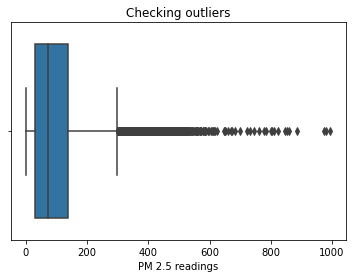

In [5]:
sns.boxplot(
    data = y,
    x = "pm2.5"
)
plt.xlabel("PM 2.5 readings")
plt.title("Checking outliers");

**Comment:** Readings above 500 are considered outliers

**Task 4 (b):** Check the presence of outliers in the target `"PM 2.5"` readings using a histogram

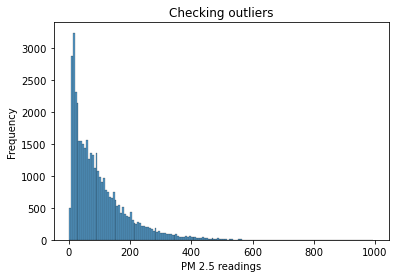

In [6]:
sns.histplot(
    data = y,
    x = "pm2.5"
)
plt.ylabel("Frequency")
plt.xlabel("PM 2.5 readings")
plt.title("Checking outliers");

**Comment:** Remove the outliers in the dataset

**Task 5:** Visualize the dataset after the outliers in the target `"PM 2.5"` have been removed

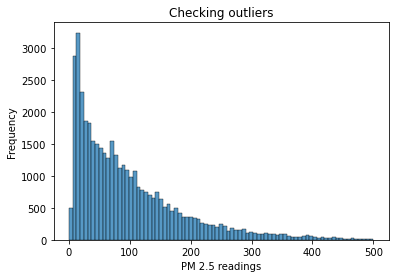

In [12]:
sns.histplot(
    data = y,
    x = "pm2.5"
)
plt.xlabel("PM 2.5 readings")
plt.ylabel("Frequency")
plt.title("Checking outliers");

**Task 6 (a):** Visualize the target `"PM 2.5"` on a line plot

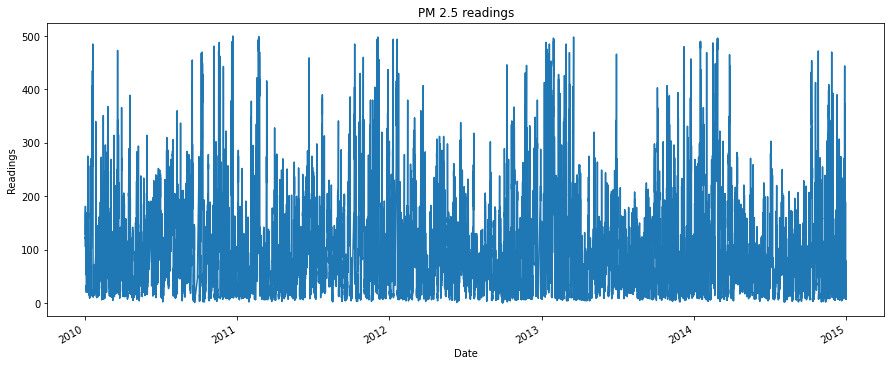

In [13]:
fig, ax = plt.subplots(figsize = [15, 6])
y["pm2.5"].plot()
plt.title("PM 2.5 readings")
plt.xlabel("Date")
plt.ylabel("Readings");

**Comment:** Express the dataframe as a series

**Task 6(b):** Plot the rolling average of the target `"PM 2.5"` by 1 week to show weekly trends

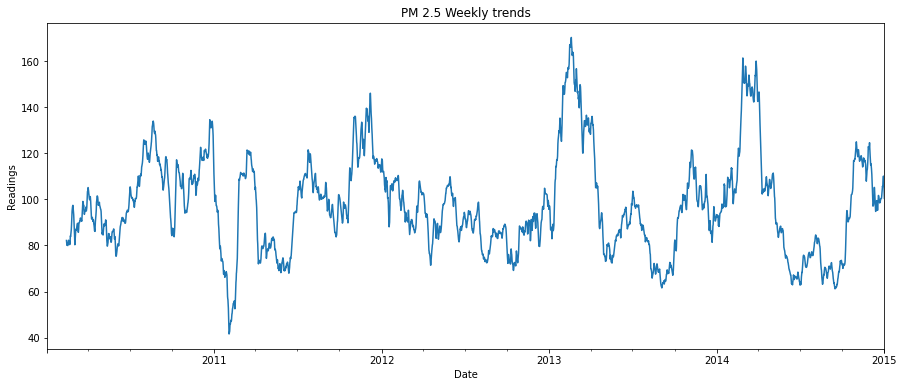

In [15]:
fig, ax = plt.subplots(figsize = [15, 6])
y.rolling(168).mean().plot()
plt.title("PM 2.5 Weekly trends")
plt.xlabel("Date")
plt.ylabel("Readings");

**Task 7:** Visualize the autocorrelation

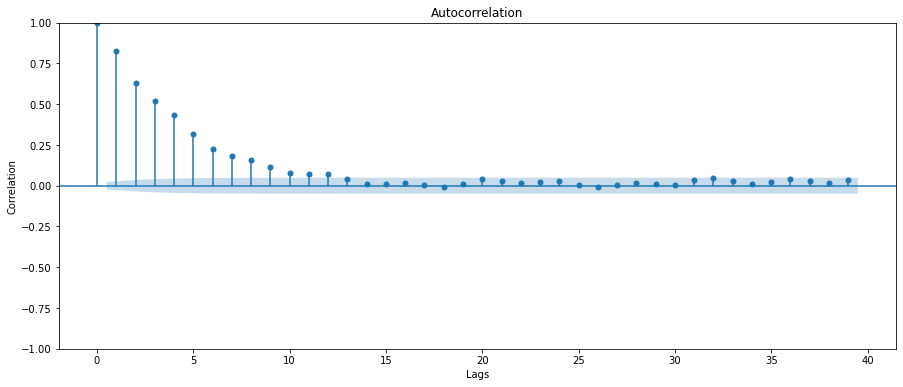

In [17]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_acf(y, ax = ax)
plt.xlabel("Lags")
plt.ylabel("Correlation");

**Task 7 (b):** Visualize the partial autocorrelation

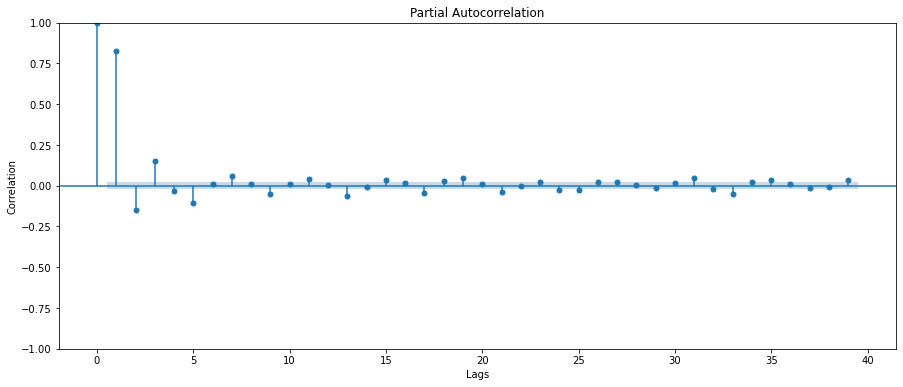

In [18]:
fig, ax = plt.subplots(figsize = [15, 6])
plot_pacf(y, method = 'ywm', ax = ax)
plt.xlabel("Lags")
plt.ylabel("Correlation");

## Split

**Task 8:** Calculate the cut-off position

In [20]:
cut_off = int(len(y) * 0.80)
cut_off

5840

**Task 9:** Create a horizontal split

In [21]:
y_train, y_test = y.iloc[:cut_off],y.iloc[cut_off:]
y_train[:5]

timestamp
2010-01-02 06:00:00+08:00    154.250000
2010-01-02 12:00:00+08:00    121.333333
2010-01-02 18:00:00+08:00    152.666667
2010-01-03 00:00:00+08:00    160.000000
2010-01-03 06:00:00+08:00     92.500000
Freq: 6H, Name: pm2.5, dtype: float64

# Build Model

## Baseline

**Task 10:** Calculate the baseline mean absolute error of this model

In [22]:
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 64.54


## Iterate

**Task 11:** Initialize hyperparemeter lists `"p_params"` and `"q_params"` to tune this model

In [23]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

**Task 12:** Tune the hyperparemeters to get a dictionary of possible metrics (mean absolute deviation)

In [24]:
mae_dict = {}
for p in p_params:
    mae_dict[p] = []
    for q in q_params:
        start_time = time.time()
        order = (p, 0, q)
        model = ARIMA(y_train, order = order).fit()
        y_pred = model.predict()
        mae_dict[p].append(mean_absolute_error(y_train, y_pred))
        end_time = round(time.time() - start_time, 2)
        print(f'Training order {order} in {end_time} seconds')


Training order (0, 0, 0) in 6.8 seconds
Training order (0, 0, 1) in 1.46 seconds
Training order (0, 0, 2) in 1.83 seconds
Training order (8, 0, 0) in 2.67 seconds
Training order (8, 0, 1) in 8.71 seconds
Training order (8, 0, 2) in 21.55 seconds
Training order (16, 0, 0) in 5.64 seconds
Training order (16, 0, 1) in 23.44 seconds
Training order (16, 0, 2) in 54.86 seconds
Training order (24, 0, 0) in 24.36 seconds
Training order (24, 0, 1) in 90.55 seconds
Training order (24, 0, 2) in 138.34 seconds


## Evaluate

**Task 12:** Express the metrics as a dataframe

In [25]:
mae_df = pd.DataFrame(mae_dict)
mae_df

,0,8,16,24
0,64.544495,31.922162,31.775381,31.665902
1,43.810785,31.899539,31.757264,31.662795
2,37.622420,31.287219,31.470639,31.340893


**Task 12:** Visualize the metrics on a correlation heatmap

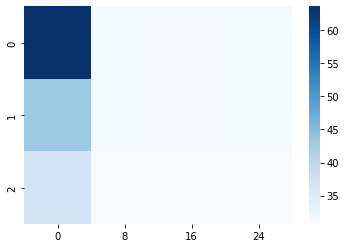

In [28]:
sns.heatmap(mae_df, cmap = "Blues");

**Comment:** The selected metric has an `"order"` of (8, 0, 0)

**Task 13:** Rebuild the model with the selected `"order"`

In [26]:
order = (8, 0, 0)
model = ARIMA(y_train, order = order).fit()
y_pred = model.predict()

**Task 16:** Generate new test predictions using a walk forward validation

In [29]:
y_test_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model_wfv = ARIMA(history, order = order).fit()
    next_pred = model_wfv.forecast()
    y_test_wfv = y_test_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_test_wfv.head()

2014-01-01 06:00:00+08:00    43.584167
2014-01-01 12:00:00+08:00    54.222841
2014-01-01 18:00:00+08:00    72.196529
2014-01-02 00:00:00+08:00    32.333948
2014-01-02 06:00:00+08:00    65.789733
Freq: 6H, dtype: float64

**Task 17:** Calculate the new test mean absolute error

In [30]:
mae_test = mean_absolute_error(y_test_wfv, y_test)
print("Test MAE:", round(mae_test, 2))

Test MAE: 31.23


**Task 18:** Visualize the residual of the model

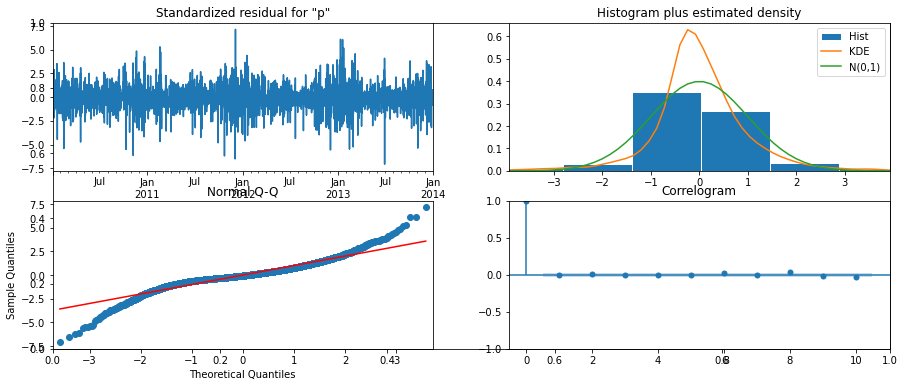

In [31]:
fig, ax = plt.subplots(figsize = [15, 6])
model.plot_diagnostics(fig = fig);

# Communication

**Task 19:** Create a dataframe for the test predictions

In [32]:
data = {"Actual Readings" : y_test, "Model Readings" :y_test_wfv }
df_pred = pd.DataFrame(data)
df_pred.head()

,Actual Readings,Model Readings
2014-01-01 06:00:00+08:00,42.500000,43.584167
2014-01-01 12:00:00+08:00,73.833333,54.222841
2014-01-01 18:00:00+08:00,30.166667,72.196529
2014-01-02 00:00:00+08:00,42.333333,32.333948
2014-01-02 06:00:00+08:00,142.333333,65.789733


**Task 20:** Visualize the readings on a line plot

In [33]:
fig = px.line(
    df_pred,
    labels={"value": "P2"},
    title = "Time series of the PM 2.5 readings"
)
fig.update_layout(xaxis_title = "Date",yaxis_title = "PM 2.5 readings")
fig.show();